In [1]:
import torch  
import json 
from omegaconf import DictConfig, OmegaConf 
from hydra import initialize, compose 
from types import SimpleNamespace

OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16} 

from utils_pdhg import *


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=attn_pd_adamw",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer attn_pd_adamw and learning rate 0.001
[AttnPDAdamW] lr=0.001, betas=(0.95, 0.95), eps=1e-08, wd=0.0, qk_lr_scale=1.0, max_norm_tr=0.01, pdhg_iters=100, warm_start=False
    momentum=False, diag_scaling=True, accel=False, pd_type='pdhg', halpern_start=5, reflected_pdhg=False
Set pass_loss to False for optimizer AttnPDAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 6.795860290527344
In rank: 0, time taken for epoch 1 :  68.25166320

In [3]:
with initialize(config_path="../hydra_conf", version_base=None):
    config = compose(config_name="config", overrides=overrides)

# Paste the hydra_run_dir printed by main() here:
output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw/bs-4-lr-0.001-wd-0"

output_path = make_output_path_hydra(config, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/outputs/gpt-tiny/default/tiny_shakespeare/attn_pd_adamw/bs-4-lr-0.001-wd-0/attn_pd_adamw-lr-0.001-constant-linear-9ff82b8d26e3f2ba6c86bdc3142aff9f.json


iteration=0
  layer  W_q_norm  W_k_norm  G_q_norm  G_k_norm  Y_norm
0     0  0.059369  0.061276  0.013209  0.013600     0.0
1     1  0.016468  0.017101  0.003659  0.003802     0.0
2     2  0.008899  0.009689  0.001973  0.002151     0.0
3     3  0.007691  0.007547  0.001705  0.001678     0.0


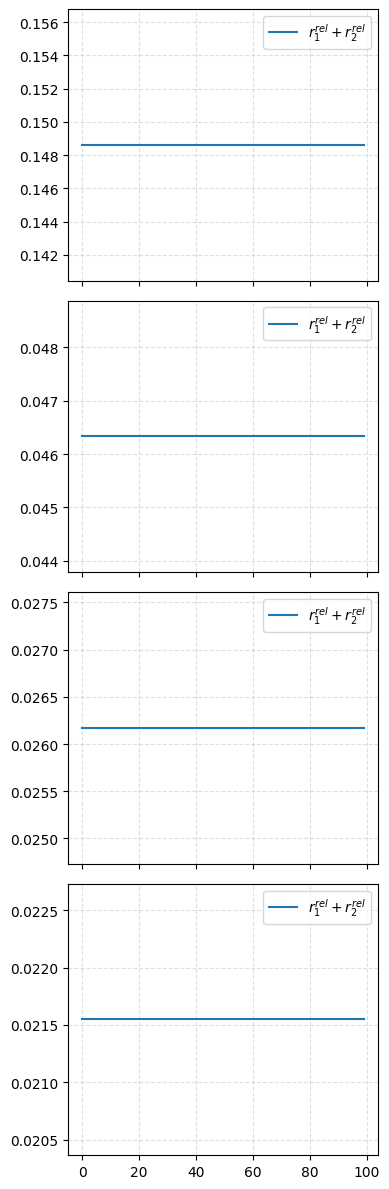

In [15]:
it = 0
print(f"iteration={it}")
import pandas as pd
it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)

plot_residuals_layers(logger.pdhg_residuals[it], yscale=False, dual_scale=False, agg_sum=True, plot_res=['rel'])

iteration=50
  layer      W_q_norm      W_k_norm      G_q_norm      G_k_norm  Y_norm
0     0  6.273538e-01      2.744689  1.555107e-02  8.853258e-02     0.0
1     1  1.263312e+06  93629.015625  8.739601e-04  1.791960e-05     0.0
2     2  4.007482e-02      0.008669  3.005593e-11  6.777124e-12     0.0
3     3  1.366821e-02      0.010824  2.649913e-11  2.146255e-11     0.0


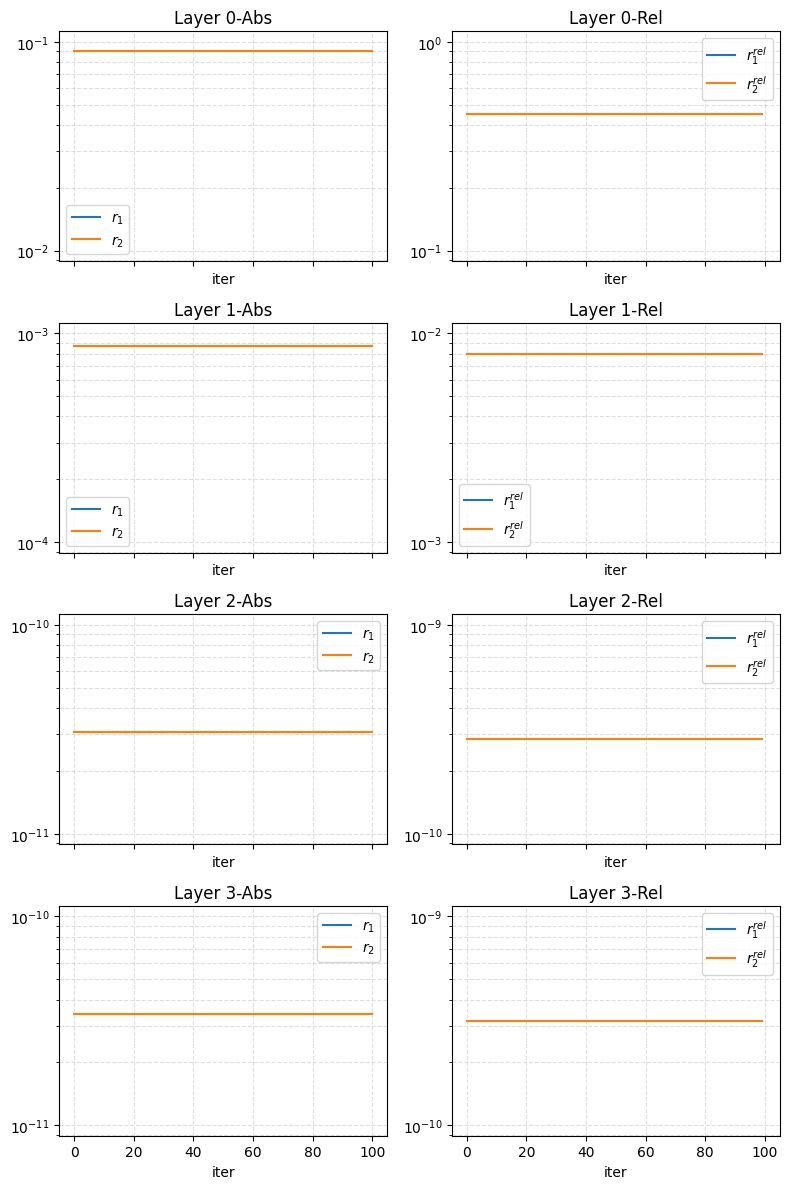

In [5]:
it = 50
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)

iteration=-1
  layer     W_q_norm     W_k_norm      G_q_norm      G_k_norm   Y_norm
0     0    35.192150     3.537311  8.575361e-01  3.536261e-01  0.67184
1     1  1669.413696  1255.545044  2.774235e-06  4.384677e-07  0.00000
2     2     0.000019     0.001274  1.800191e-12  3.427360e-11  0.00000
3     3     0.000002     0.000032  3.215318e-13  1.223526e-12  0.00000


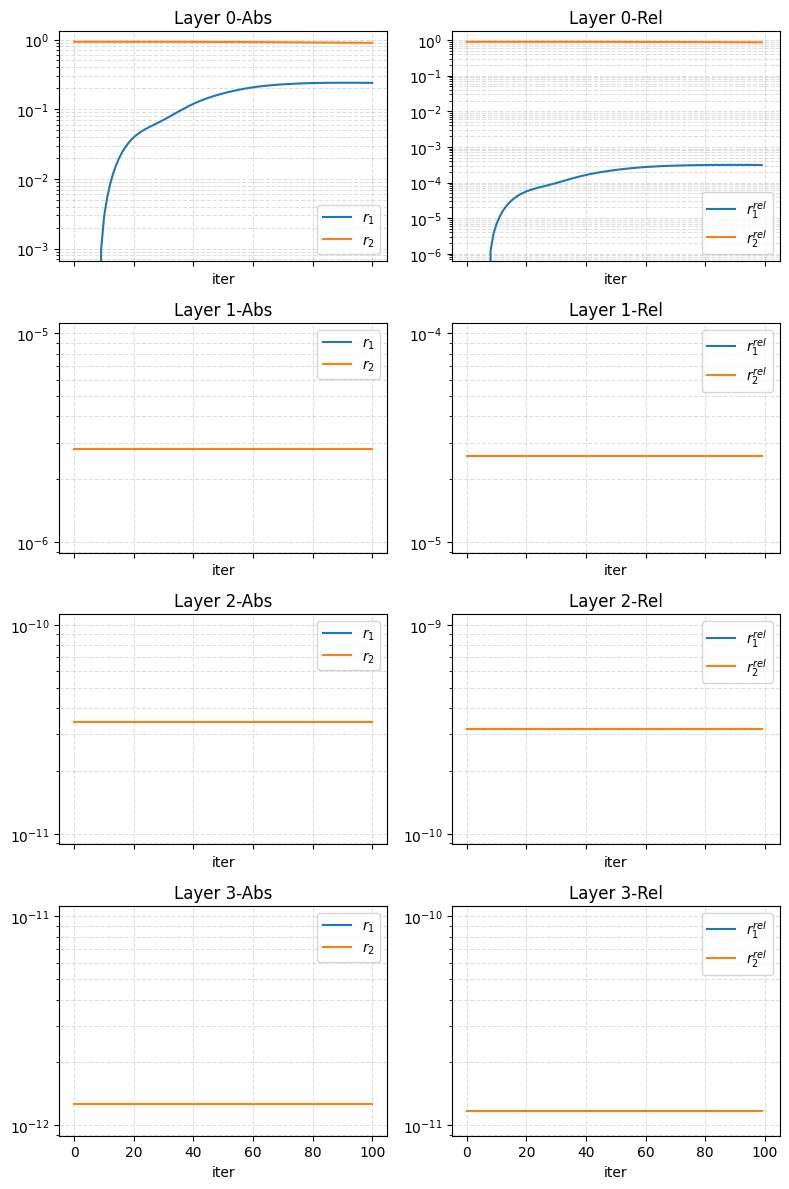

In [6]:
it = -1
print(f"iteration={it}")

it0 = logger.pdhg_residuals[it]

rows = []
for layer_idx, layer_res in sorted(it0.items(), key=lambda x: int(x[0])):
    rows.append({
        "layer": layer_idx, "W_q_norm": layer_res["W_q_norm"], "W_k_norm": layer_res["W_k_norm"],
        "G_q_norm": layer_res["G_q_norm"], "G_k_norm": layer_res["G_k_norm"],
        "Y_norm": layer_res["Y_norm"], #"dual_vals": layer_res["dual_vals"][-1], 
    })

df = pd.DataFrame(rows)
print(df)


plot_residuals_layers(logger.pdhg_residuals[it], dual_scale=False)